In [3]:
import numpy as np
import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image

from tqdm import tqdm
import os 


In [4]:
directory = '/n/home12/hongwei/HONGWEI/lagranto.ecmwf/Simulation/run_10yr_2000_01'
filenames = ['/traj.20000101','/traj.20000102','/traj.20000103', \
             '/traj.20000104','/traj.20000105','/traj.20000106', \
             '/traj.20000107','/traj.20000108','/traj.20000109', \
             '/traj.20000110']

In [18]:
N_head = 5 # first 5 lines are head lines, not include data
N_column = 4

Nx = 36
Ny = 21
Nz = 5
N_parcel = 3780

if Nx*Ny*Nz!=N_parcel: print('ERROR: parcel number is wrong!')
    
N_inject = 4

file1 = open(directory+filenames[0], 'r')
Lines = file1.readlines()
Nt = int( (len(Lines)-4)/N_parcel - 1 ) # 2928

In [19]:
data = np.zeros((N_parcel, Nt, N_column, N_inject))

for i_inject in range(N_inject):
    file1 = open(directory+filenames[i_inject], 'r')
    print('Begin: '+filenames[i_inject])
    Lines = file1.readlines()

    count = 0
    # Strips the newline character
    for line in tqdm(Lines):
        count += 1
    
        if count>=5:
            i = count-5
            i_parcel = math.floor( i / (Nt+1) ) # Nt time lines plue 1 empty line
            i_t = i%(Nt+1)
        
            if i_t!=0:
                a = line.split()

                if i_t==1:
                    if float(a[0])!=0.0: print('ERROR: first time is not 0 !!!')
                
                data[i_parcel,i_t-1,1,i_inject] = float(a[1]) # lon
                data[i_parcel,i_t-1,2,i_inject] = float(a[2]) # lat
                data[i_parcel,i_t-1,3,i_inject] = float(a[3]) # lev
                
    file1.close()

Begin: /traj.20000101


100%|██████████| 110474284/110474284 [05:24<00:00, 340637.35it/s]


Begin: /traj.20000102


100%|██████████| 110474284/110474284 [05:21<00:00, 343730.83it/s]


Begin: /traj.20000103


100%|██████████| 110474284/110474284 [05:21<00:00, 343814.45it/s]


Begin: /traj.20000104


100%|██████████| 110474284/110474284 [05:24<00:00, 340910.89it/s]


Begin: /traj.20000105


100%|██████████| 110474284/110474284 [05:17<00:00, 347486.49it/s]


Begin: /traj.20000106


100%|██████████| 110474284/110474284 [05:15<00:00, 350700.40it/s]


In [20]:
del file1
del Lines

In [21]:
data2 = np.zeros((Nz,Ny,Nx,Nt,N_column,N_inject))

for i_inject in tqdm(range(N_inject)):
    for iy in range(Ny):
        for iz in range(Nz):
            for ix in range(Nx):
                i_parcel = iy*(Nz*Nx) + iz*Nx + ix
                data2[iz,iy,ix,:,:,i_inject] = data[i_parcel,:,:,i_inject]


100%|██████████| 6/6 [00:41<00:00,  6.94s/it]


In [22]:
P_cont = 200 # [hPa]

In [23]:
# lifetime = np.zeros((Nz,Ny,Nx))

# for iy in tqdm(range(Ny)):
#     for iz in range(Nz):
#         for ix in range(Nx):
#             Num = sum(1 for i in data2[iz,iy,ix,:,3] if i<=P_cont)
#             lifetime[iz,iy,ix] = Num*3/24 # hour to day

In [24]:
lifetime = np.zeros((Nz,Ny,Nx,N_inject))

for i_inject in tqdm(range(N_inject)):
    for iy in range(Ny):
        for iz in range(Nz):
            for ix in range(Nx):
                Num = 0
                for i in data2[iz,iy,ix,:,3,i_inject]:
                    Num = Num+1
                    if i>=P_cont: 
                        lifetime[iz,iy,ix,i_inject] = Num*3/24 # hour to day
                        break
            

100%|██████████| 6/6 [02:14<00:00, 22.36s/it]


In [25]:
LON = np.zeros((Ny,Nx))
LAT = np.zeros((Ny,Nx))

for iy in range(Ny):
    for ix in range(Nx):
        LON[iy,ix] = data2[0,iy,ix,0,1,0]
        LAT[iy,ix] = data2[0,iy,ix,0,2,0]

In [26]:
# Sort lat dimension from min to max [-20:20]
print(LAT[:,0])

index = np.argsort(LAT[:,0])

LAT[:,:] = LAT[index,:]
LON[:,:] = LON[index,:]
lifetime[:,:,:,:] = lifetime[:,index,:,:]
data2[:,:,:,:,:,:] = data2[:,index,:,:,:,:]

print(LAT[:,0])

[  0.  10. -10.  12. -12.  14. -14.  16. -16.  18. -18.   2.  -2.  20.
 -20.   4.  -4.   6.  -6.   8.  -8.]
[-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.
   8.  10.  12.  14.  16.  18.  20.]


In [29]:
print(lifetime.shape)
Pressure = [100, 70, 50, 40, 25] # hPa
# Pressure = [100, 85, 75, 65, 55] # hPa

Life_mean = np.mean(lifetime, axis=(1,2,3))
Life_std = np.std(lifetime, axis=(1,2,3))

(5, 21, 36, 6)


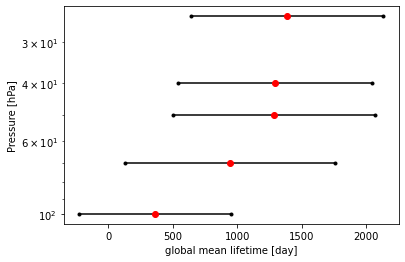

In [30]:

for i in range(len(Pressure)):
    Xs = [Life_mean[i]-Life_std[i], Life_mean[i]+Life_std[i]]
    Ys = [Pressure[i], Pressure[i]]
    plt.plot(Xs, Ys, 'k')

    
plt.plot(Life_mean, Pressure, 'ro')
plt.plot(Life_mean-Life_std, Pressure, 'k.')
plt.plot(Life_mean+Life_std, Pressure, 'k.')

plt.xlabel('global mean lifetime [day]')
plt.ylabel('Pressure [hPa]')

plt.yscale('log')
plt.gca().invert_yaxis()

In [31]:
Life_Q1 = np.zeros(5)
Life_Q2 = np.zeros(5)
Life_Q3 = np.zeros(5)

for i in range(len(Pressure)):
    Life_Q1[i] = np.percentile(lifetime[i,:,:,:].flatten(), 25)  # Q1
    Life_Q2[i] = np.percentile(lifetime[i,:,:,:].flatten(), 50)  # Q1
    Life_Q3[i] = np.percentile(lifetime[i,:,:,:].flatten(), 75)  # Q1

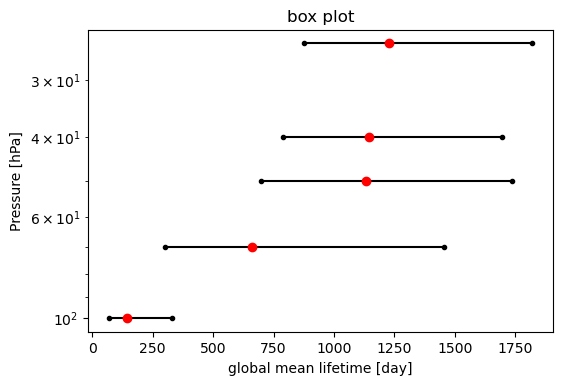

In [32]:
plt.figure(dpi=100)

for i in range(len(Pressure)):
    Xs = [Life_Q1[i], Life_Q3[i]]
    Ys = [Pressure[i], Pressure[i]]
    plt.plot(Xs, Ys, 'k')

    
plt.plot(Life_Q2, Pressure, 'ro')
plt.plot(Life_Q1, Pressure, 'k.')
plt.plot(Life_Q3, Pressure, 'k.')

plt.xlabel('global mean lifetime [day]')
plt.ylabel('Pressure [hPa]')
plt.title('box plot')

plt.yscale('log')
plt.gca().invert_yaxis()

In [36]:
Life_Inject_Mean = np.mean(lifetime, axis=3)

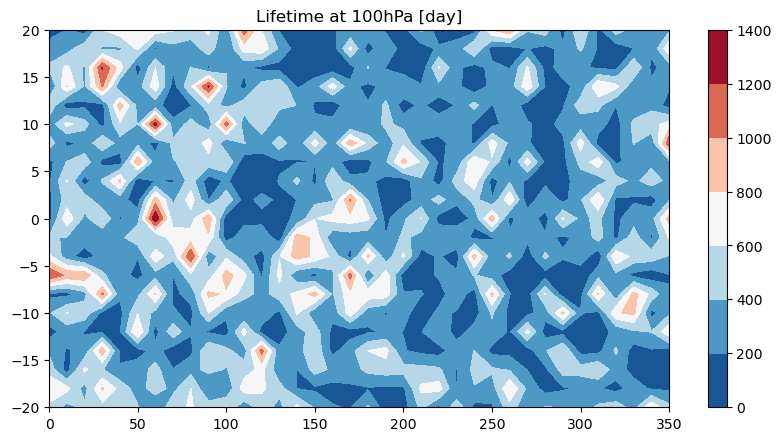

In [39]:
# contourf

plt.figure(figsize=(10,5), dpi=100)

X = LON
Y = LAT

Z = Life_Inject_Mean[0,:,:] # 100 hPa

plt.contourf(X, Y, Z, cmap='RdBu_r')
# plt.pcolormesh(X, Y, Z, cmap='RdBu')
plt.colorbar();

plt.title('Lifetime at 100hPa [day]');

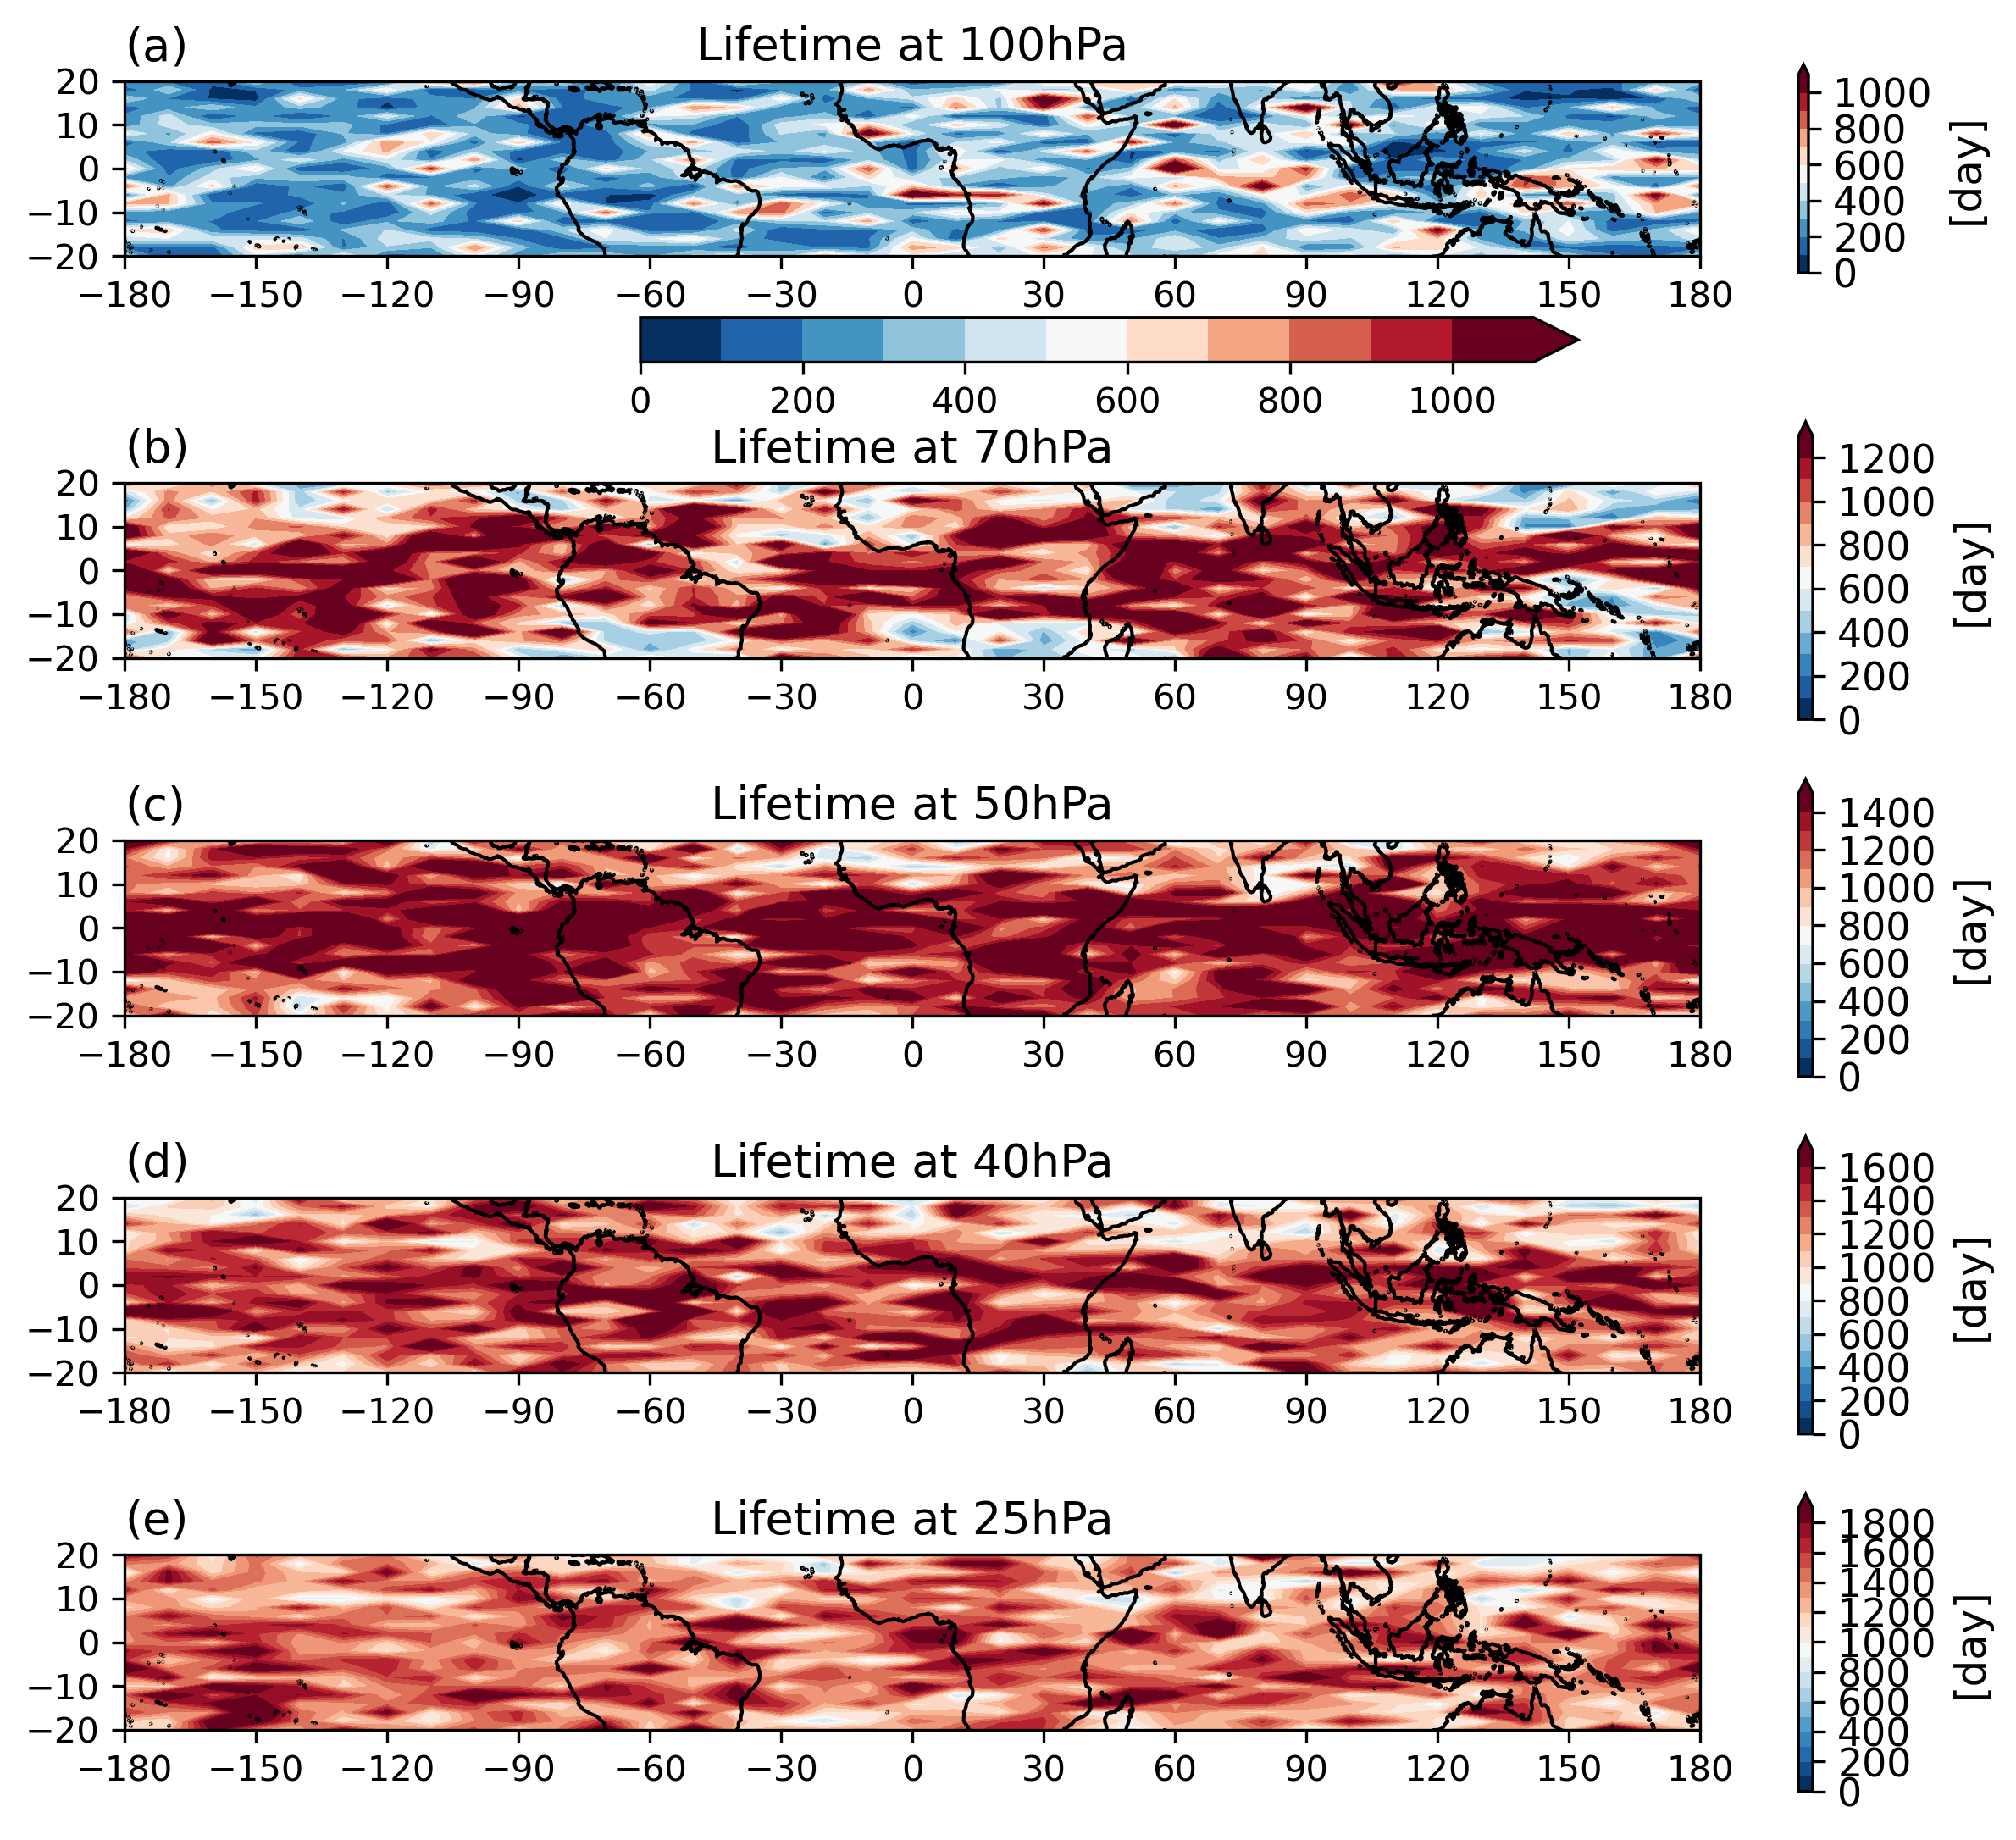

In [41]:
fig = plt.figure(figsize=(10,9), dpi=300);
# gs = gridspec.GridSpec(1, 11, figure=fig)
# plt.suptitle('Day: '+str(i+1), fontsize=16);

# ax1

# ax1 = plt.subplot(3,1,1)
projection=ccrs.PlateCarree()
# ax1 = fig.add_subplot(projection=ccrs.PlateCarree())
ax1 = plt.subplot(5, 1, 1, projection=ccrs.PlateCarree());
# ax1.set_global()
    
# ax1.gridlines(x_inline=True)    
ax1.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax1.set_yticks(np.linspace(-20, 20, 5), crs=projection)
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()
# ax1.xaxis.set_major_formatter(lon_formatter)
# ax1.yaxis.set_major_formatter(lat_formatter)
#     z = ma.masked_where(LA_Zsum[i,:,:] <= 1e-10, LA_Zsum[i,:,:])

levels =  np.arange(0,1200,100)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = LAT[:,0]
lon0 = LON[0,:]
datas = Life_Inject_Mean[0,:,:]
cyclic_datas = add_cyclic_point(datas)
datas, lon0_cyclic = add_cyclic_point(datas, coord=lon0)
    
ax1_contours = ax1.contourf(lon0_cyclic, lat0, datas, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
cb1 = plt.colorbar(ax1_contours, ax=ax1, orientation="horizontal")
cb1 = plt.colorbar(ax1_contours, ax=ax1)
cb1.ax.tick_params(labelsize=11)
cb1.set_label('[day]', fontsize=12)
    
ax1.coastlines();
ax1.set_title('Lifetime at 100hPa', fontsize=13);
ax1.set_title('(a)', fontsize=13, loc='left');

# ax2

ax2 = plt.subplot(5, 1, 2, projection=ccrs.PlateCarree());
    
ax2.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax2.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(0,1400,100)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = LAT[:,0]
lon0 = LON[0,:]
datas = Life_Inject_Mean[1,:,:]
cyclic_datas = add_cyclic_point(datas)
datas, lon0_cyclic = add_cyclic_point(datas, coord=lon0)
    
ax2_contours = ax2.contourf(lon0_cyclic, lat0, datas, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
cb2 = plt.colorbar(ax2_contours, ax=ax2)
cb2.ax.tick_params(labelsize=11)
cb2.set_label('[day]', fontsize=12)
    
ax2.coastlines();
ax2.set_title('Lifetime at 70hPa', fontsize=13);
ax2.set_title('(b)', fontsize=13, loc='left');

# ax=3

ax3 = plt.subplot(5, 1, 3, projection=ccrs.PlateCarree());
    
ax3.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax3.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(0,1600,100)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = LAT[:,0]
lon0 = LON[0,:]
datas = Life_Inject_Mean[2,:,:]
cyclic_datas = add_cyclic_point(datas)
datas, lon0_cyclic = add_cyclic_point(datas, coord=lon0)
    
ax3_contours = ax3.contourf(lon0_cyclic, lat0, datas, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
cb3 = plt.colorbar(ax3_contours, ax=ax3)
cb3.ax.tick_params(labelsize=11)
cb3.set_label('[day]', fontsize=12)
    
ax3.coastlines();
ax3.set_title('Lifetime at 50hPa', fontsize=13);
ax3.set_title('(c)', fontsize=13, loc='left');

# ax=4

ax4 = plt.subplot(5, 1, 4, projection=ccrs.PlateCarree());
    
ax4.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax4.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(0,1800,100)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = LAT[:,0]
lon0 = LON[0,:]
datas = Life_Inject_Mean[3,:,:]
cyclic_datas = add_cyclic_point(datas)
datas, lon0_cyclic = add_cyclic_point(datas, coord=lon0)
    
ax4_contours = ax4.contourf(lon0_cyclic, lat0, datas, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
cb4 = plt.colorbar(ax4_contours, ax=ax4)
cb4.ax.tick_params(labelsize=11)
cb4.set_label('[day]', fontsize=12)
    
ax4.coastlines();
ax4.set_title('Lifetime at 40hPa', fontsize=13);
ax4.set_title('(d)', fontsize=13, loc='left');


# ax=5

ax5 = plt.subplot(5, 1, 5, projection=ccrs.PlateCarree());
    
ax5.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax5.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(0,2000,100)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = LAT[:,0]
lon0 = LON[0,:]
datas = Life_Inject_Mean[4,:,:]
cyclic_datas = add_cyclic_point(datas)
datas, lon0_cyclic = add_cyclic_point(datas, coord=lon0)
    
ax5_contours = ax5.contourf(lon0_cyclic, lat0, datas, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
cb5 = plt.colorbar(ax5_contours, ax=ax5)
cb5.ax.tick_params(labelsize=11)
cb5.set_label('[day]', fontsize=12)
    
ax5.coastlines();
ax5.set_title('Lifetime at 25hPa', fontsize=13);
ax5.set_title('(e)', fontsize=13, loc='left');

In [58]:
X.shape, Y.shape, Z.shape

((21, 36), (21, 36), (21, 36))

In [59]:
# a[0:4]:
# time, lon, lat, p
data.shape

(3780, 29225, 4)

In [60]:
# plot

for i in tqdm(np.arange(0,30,1)):
    fig = plt.figure(figsize=(12,6), dpi=100)

    ax1 = fig.add_subplot(1,1,1, projection=crs.Robinson())
    ax1.set_global()
    ax1.add_feature(cfeature.COASTLINE, edgecolor="grey")
    ax1.add_feature(cfeature.BORDERS, edgecolor="grey")
    ax1.gridlines()

    xx=data[::36,i*8,1]
    yy=data[::36,i*8,2]
    
    ax1.scatter(x=xx, y=yy,
            color="red",
            s=1,
            alpha=0.5,
            transform=crs.PlateCarree()) ## Important

#     ax1.set_title(f'time: $(i*3) hour')


    plt.tight_layout()
    plt.savefig(str(i+1)+'_xy.png', transparent=False, facecolor='w', edgecolor='w');
    plt.close();
    plt.clf();
    plt.cla();
    
        
plt.close();

100%|██████████| 30/30 [00:08<00:00,  3.41it/s]


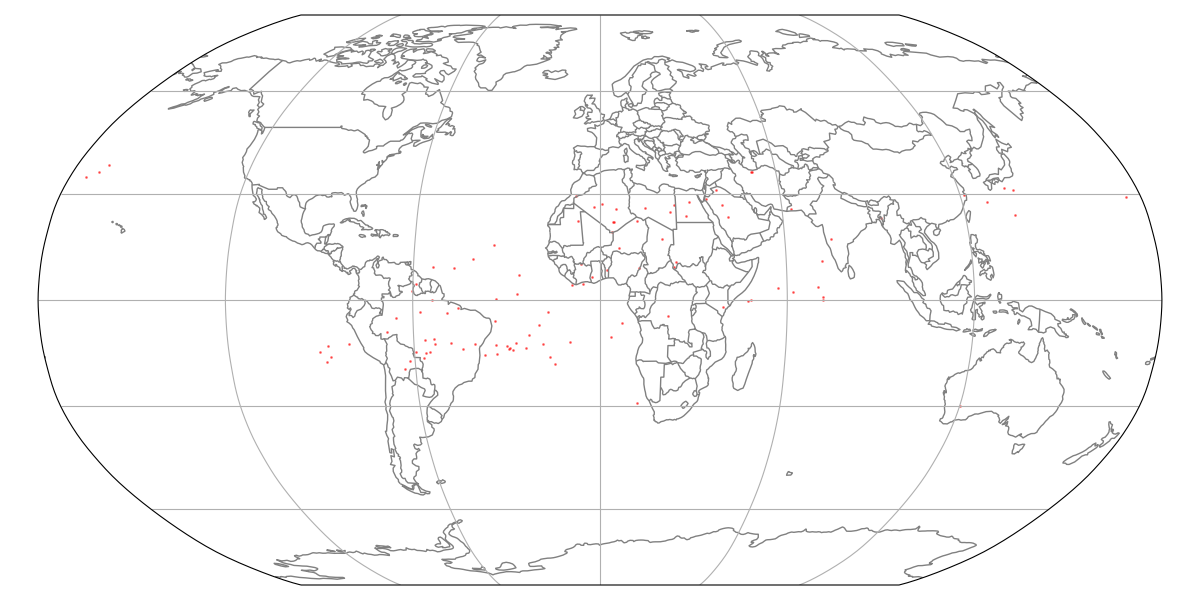

In [68]:

Image(filename=f'7_xy.png')

In [36]:
os.system('./png2gif2.sh')

0

array([   1.        ,    1.07226722,    1.149757  ,    1.23284674,
          1.32194115,    1.41747416,    1.51991108,    1.62975083,
          1.7475284 ,    1.87381742,    2.009233  ,    2.15443469,
          2.3101297 ,    2.47707636,    2.65608778,    2.84803587,
          3.05385551,    3.27454916,    3.51119173,    3.76493581,
          4.03701726,    4.32876128,    4.64158883,    4.97702356,
          5.33669923,    5.72236766,    6.13590727,    6.57933225,
          7.05480231,    7.56463328,    8.11130831,    8.69749003,
          9.32603347,   10.        ,   10.72267222,   11.49756995,
         12.32846739,   13.21941148,   14.17474163,   15.19911083,
         16.29750835,   17.475284  ,   18.73817423,   20.09233003,
         21.5443469 ,   23.101297  ,   24.77076356,   26.56087783,
         28.48035868,   30.53855509,   32.74549163,   35.11191734,
         37.64935807,   40.37017259,   43.28761281,   46.41588834,
         49.77023564,   53.36699231,   57.22367659,   61.35907

In [69]:
Np = 20

aa = np.linspace( np.log(1), np.log(1000), Np)
Bin_bdy = np.exp(aa)


Bin_mid = []
for i in range(len(Bin_bdy)-1):
    Bin_mid.append( (Bin_bdy[i]+Bin_bdy[i+1])/2 )

print(Bin_bdy)
print(Bin_mid)
Bin_bdy.shape, len(Bin_mid)

[   1.            1.43844989    2.06913808    2.97635144    4.2813324
    6.15848211    8.8586679    12.74274986   18.32980711   26.36650899
   37.92690191   54.55594781   78.47599704  112.88378917  162.37767392
  233.57214691  335.98182863  483.29302386  695.19279618 1000.        ]
[1.2192249441438314, 1.7537939847012263, 2.522744761373054, 3.628841920175356, 5.219907254689828, 7.508575007380545, 10.80070888056608, 15.536278482677847, 22.348158047813968, 32.14670544731304, 46.24142485950384, 66.51597242341566, 95.67989310180751, 137.63073154367052, 197.97491041394215, 284.77698776869516, 409.63742624277666, 589.2429100173679, 847.5963980887801]


((20,), 19)

In [95]:
N_days = 200

for i in tqdm(range( int(365*3/N_days) )):
    
    
    # (1)
    fig = plt.figure(figsize=(12,6), dpi=100)
    gs = gridspec.GridSpec(1, 11, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0:6])
    ax2 = fig.add_subplot(gs[0, 6:9])

    
    
    # 25 hpa    
    xx4=data2[4,:,:,i*8*N_days,2].flatten()
    zz4=data2[4,:,:,i*8*N_days,3].flatten()
    
    ax1.scatter(x=xx4[:], y=zz4[:],
            color="purple", label='25 hPa',
            s=1) ## Important
    
    ax1.plot((-90,90),(25,25),'purple',alpha=0.2)
    
    
    Bin_num, Bin_bdy = np.histogram(zz4, bins=Bin_bdy)
    ax2.plot(Bin_num/np.sum(Bin_num)*100, Bin_mid, 'purple', label='25 hPa')

    

    # 40 hpa
    xx3=data2[3,:,:,i*8*N_days,2].flatten()
    zz3=data2[3,:,:,i*8*N_days,3].flatten()
    
    ax1.scatter(x=xx3[:], y=zz3[:],
            color="cyan", label='40 hPa',
            s=1) ## Important
    
    ax1.plot((-90,90),(40,40),'cyan',alpha=0.2)
    
    Bin_num, Bin_bdy = np.histogram(zz3, bins=Bin_bdy)
    ax2.plot(Bin_num/np.sum(Bin_num)*100, Bin_mid, 'cyan', label='40 hPa')
    
    
    
    # 50 hpa
    xx2=data2[2,:,:,i*8*N_days,2].flatten()
    zz2=data2[2,:,:,i*8*N_days,3].flatten()
    
    ax1.scatter(x=xx2[:], y=zz2[:],
            color="orange", label='50 hPa',
            s=1) ## Important
    
    ax1.plot((-90,90),(50,50),'orange',alpha=0.2)

        
    Bin_num, Bin_bdy = np.histogram(zz2, bins=Bin_bdy)
    ax2.plot(Bin_num/np.sum(Bin_num)*100, Bin_mid, 'orange', label='50 hPa')
    
    
    
    # 70 hpa    
    xx1=data2[1,:,:,i*8*N_days,2].flatten()
    zz1=data2[1,:,:,i*8*N_days,3].flatten()
    
    ax1.scatter(x=xx1[:], y=zz1[:],
            color="blue", label='70 hPa',
            s=1) ## Important

    ax1.plot((-90,90),(70,70),'blue',alpha=0.2)
    
    
    Bin_num, Bin_bdy = np.histogram(zz1, bins=Bin_bdy)
    ax2.plot(Bin_num/np.sum(Bin_num)*100, Bin_mid, 'blue', label='70 hPa')
    
        

    # 100 hpa
    xx0=data2[0,:,:,i*8*N_days,2].flatten()
    zz0=data2[0,:,:,i*8*N_days,3].flatten()
    
    ax1.scatter(x=xx0[:], y=zz0[:],
            color="red", label='100 hPa',
            s=1) ## Important
    ax1.plot((-90,90),(100,100),'red',alpha=0.2)
        
    
    Bin_num, Bin_bdy = np.histogram(zz0, bins=Bin_bdy)
    ax2.plot(Bin_num/np.sum(Bin_num)*100, Bin_mid, 'red', label='100 hPa')
    
    
    
    ax1.set_xlim([-90,90])
    ax1.set_ylim([1, 1000])
    
    ax1.set_yscale('log')
#     plt.gca().invert_yaxis()
    ax1.invert_yaxis()
    
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel('Pressure [hPa]')
    ax1.set_title('Day: ' + str(i*N_days))
    ax1.legend()

    
    #
    ax2.set_ylim([1, 1000])
    ax2.set_yscale('log')
    ax2.set_ylabel('Pressure [hPa]')
    ax2.invert_yaxis()
    ax2.set_xlim([0, 50])
    ax2.set_xlabel('Particle number percentage [%]')
    ax2.legend()

    
    #
    
    
    
    plt.tight_layout()
    plt.savefig(str(i+1)+'_yz.png', transparent=False, facecolor='w', edgecolor='w');
    plt.close();
    plt.clf();
    plt.cla();
    
        
plt.close();

100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


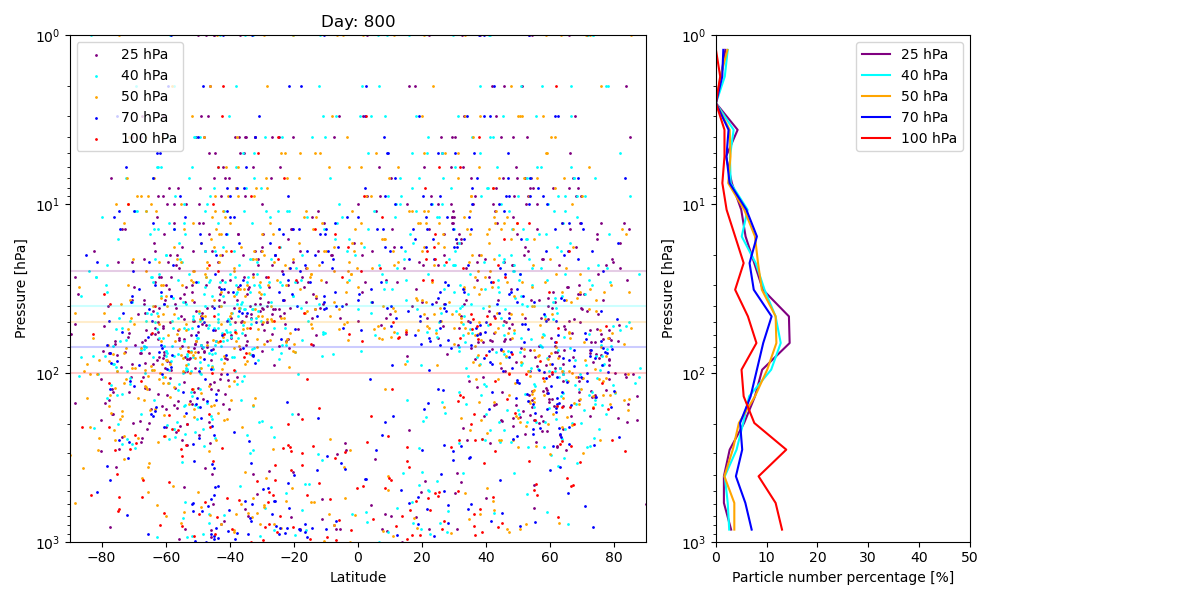

In [100]:
Image(filename=f'5_yz.png')

In [19]:
os.system('./png2gif2_yz.sh')

0

In [22]:
for i in range(3):
    for j in range(5):
        print(i,j)
        if j==4: break

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
